# Matrix Factorisation for Drug Target Interaction
This notebook will provide a run through of the project undertaken at the University of Sheffield for the Data Analytics MSc.
## Background
Applying machine learning to the drug target interaction prediction problem can have a very positive impact on the drug development process. By reducing the amount of screening required and also enlarging the search space to avoid any missing potential drugs there is potential for pharmaceutical companies to save large amounts of money. This project uses two different matrix factorisation methods in an attempt to estimate the binding affinity of a drug and a target. 
## Import dependencies

In [1]:
# import modules
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from tdc.multi_pred import DTI
import torch
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem

## Data Loading and Exploration
The data is provided by the Therapeutics Data Commons (TDC) ([link here](https://tdcommons.ai/multi_pred_tasks/dti/)). The data base used is BindingDB and in particular the Kd data set. There are two other data sets included in this database; ic50 and Ki, which this exact method would still apply. To begin the project lets load in the Kd dataset.

In [2]:
# load in the Kd dataset
# method also works with IC50 and Ki datasets
data = DTI(name = 'BindingDB_Kd')
data.convert_to_log(form = 'binding') # converted binding affinity values to log space for more stable training

Found local copy...
Loading...
Done!
To log space...


In [3]:
# split data using the tdc module random split
split = data.get_split(seed = 42, frac=[0.6, 0.05, 0.35])
train = split['train']
test = split['test']

In [4]:
# Combine training and test datasets
df = pd.concat([train, test], ignore_index=True, sort=False)

Now that the data is loaded in lets have a look at it

In [5]:
df.head()

,Drug_ID,Drug,Target_ID,Target,Y
0,4293.0,NS(=O)(=O)c1ccc(S(=O)(=O)NCc2cccs2)s1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.031517
1,1611.0,NS(=O)(=O)c1cc2c(s1)S(=O)(=O)N(Cc1cccs1)CC2O,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.522879
2,3013848.0,CN[C@H]1CN(c2cccc(OC)c2)S(=O)(=O)c2sc(S(N)(=O)...,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.698970
3,4369101.0,CN[C@@H]1CN(c2cccc(OC)c2)S(=O)(=O)c2sc(S(N)(=O...,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,8.744727
4,1514.0,COc1cccc(N2C=Cc3cc(S(N)(=O)=O)sc3S2(=O)=O)c1,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,9.638272


The `Drug` column shows the SMILE representation of the drugs and the `Target` column is the protein sequence of the target. The final column `Y` is the binding affinity which has previously been converted to log space.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49660 entries, 0 to 49659
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Drug_ID    49660 non-null  float64
 1   Drug       49660 non-null  object 
 2   Target_ID  45536 non-null  object 
 3   Target     49660 non-null  object 
 4   Y          49660 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.9+ MB


While the dataset does include IDs for both drugs and targets the Target_ID column has some NaN values that the Target column does not have, therefore this will not be used. 

For a rough idea of the sparsity of the dataset lets see how many unique drugs and targets there are.

In [7]:
unique_drugs = pd.unique(df['Drug'])
unique_targets = pd.unique(df['Target'])

print('Unique drugs: ', len(unique_drugs))
print('Unique targets: ', len(unique_targets))

Unique drugs:  10313
Unique targets:  1397


With approximately 50,000 data entries and 10,000 unique drugs the data set is looking pretty sparse.

## Data pre-processing
The matrix factorisation method used will require an index for each unique drug and target, this is done with the enumerate function in python.

In [8]:
# train = train[['Drug_ID', 'Drug', 'Target', 'Y']].dropna()
# train = train.reset_index(drop=True)

# enumerate drugs and targets for easy indexing
ID_to_Drug = dict(enumerate(list(dict.fromkeys(train['Drug'])))) # maybe that it is not Drug_ID
ID_to_Target = dict(enumerate(list(dict.fromkeys(train['Target']))))

Drug_to_ID = dict((v,k) for k,v in ID_to_Drug.items())
Target_to_ID = dict((v,k) for k,v in ID_to_Target.items())

Now each unique drug and target has a number associated with it starting from zero that will be used to index for the matrix factorisation model. This dictionary code is then applied to the training set so each drug and target in the data set is represented by their ID number. The function also prepares the data set for PyTorch's Dataloader.

In [9]:
def data_loader(data, drug_dict, target_dict):
    # allows data to be correctly passed in to PyTorch DataLoader
    
    # apply ID dictionary to both drugs and targets
    data["Drug_DictID"] = data["Drug"].apply(lambda x:drug_dict.get(x))
    data["Target_DictID"] = data["Target"].apply(lambda x:target_dict.get(x))
    data = data.dropna()

    # convert data into expected data types
    drug_ID = data["Drug_DictID"].to_numpy()
    target_ID = data["Target_DictID"].to_numpy()
    features = np.vstack((drug_ID, target_ID)).T
    label = data['Y'].to_numpy()
    return features, label

In [10]:
x_train, y_train = data_loader(train, Drug_to_ID, Target_to_ID)
x_test, y_test = data_loader(test, Drug_to_ID, Target_to_ID)

The training and test data sets are now set up as ($N$, 2) arrays where $N$ is the number of entries in the dataset. The first column represents the drugs and the second column represents the targets.

In [11]:
x_train

array([[   0,    0],
       [   1,    0],
       [   2,    0],
       ...,
       [7532, 1248],
       [7301, 1240],
       [7301, 1240]], dtype=int64)

The next step to prepare the data is to use the PyTorch `Dataloader` function so that it can be passed into the PyTorch model.

In [12]:
class RatingDataset(Dataset):
    def __init__(self, train, label):
        self.feature_ = train
        self.label_ = label

    def __len__(self):
        # return size of dataset
        return len(self.feature_)

    def __getitem__(self, idx):
        return torch.tensor(self.feature_[idx], dtype=torch.long), torch.tensor(self.label_[idx], dtype=torch.float)

In [13]:
bs = 100 # batch size
torch.manual_seed(42)

train_dataloader = DataLoader(RatingDataset(x_train, y_train), batch_size=bs, shuffle=True)
test_dataloader = DataLoader(RatingDataset(x_test, y_test), batch_size=bs)

Now the data is prepared and ready to be implemented into the models.

## Base Matrix Factorisation Model

The first model to be tested has been called the base matrix factorisation model. This is the standard method for matrix factorisation where predictions are be obtained via $A*B^T=Y$ where $A$ is a matrix of dimensions ($N_d, f$) where $N_d$ is the number of unique drugs and f is the number of latent factors,and where $B$ is a matrix of dimensions ($N_t, f$) where $N_t$ is the number of unique targets.

This matrix multiplication then results in $Y$ which has dimensions ($N_d, N_t$) where every value contains the predicted binding affinity of the respective drug and target. This starts with defining a PyTorch module for the model, the code for this was obtained from a [Medium article](https://medium.com/@rinabuoy13/explicit-recommender-system-matrix-factorization-in-pytorch-f3779bb55d74). This model provides a slight alteration where a bias is added for the drugs and targets.

### Creating the model

In [14]:
class MatrixFactorization(torch.nn.Module):

    def __init__(self, n_users, n_items, n_factors):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)

        self.user_biases = torch.nn.Embedding(n_users, 1)
        self.item_biases = torch.nn.Embedding(n_items, 1)
        self.user_biases.weight.data.fill_(0.)
        self.item_biases.weight.data.fill_(0.)

    def forward(self, user, item):
        pred = self.user_biases(user) + self.item_biases(item)
        pred += (self.user_factors(user) * self.item_factors(item)).sum(1, keepdim=True)
        return pred.squeeze()

With the class for the model defined lets create it.

In [15]:
n_factors = 20 # number of latent factors

MF_model = MatrixFactorization(len(Drug_to_ID), len(Target_to_ID), n_factors)

### Model Training

The next step is to train the model, the following code was obtained from the same [Medium article](https://medium.com/@rinabuoy13/explicit-recommender-system-matrix-factorization-in-pytorch-f3779bb55d74) with some minor changes. This code allows for training with a GPU which helps to reduce training time.

In [16]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
loss_func = torch.nn.MSELoss()

MF_model.to(dev)

train_losses = []
test_losses = []

num_epochs = 100

for epoch in range(0, num_epochs):
    count = 0
    cum_loss = 0.
    for i, (train_batch, label_batch) in enumerate(train_dataloader):
        count = 1 + i
        # Predict and calculate loss for user factor and bias
        optimizer = torch.optim.SGD([MF_model.user_biases.weight, MF_model.user_factors.weight,
                                     MF_model.item_biases.weight, MF_model.item_factors.weight],
                                    lr=0.05, weight_decay=1e-5)
        prediction = MF_model(train_batch[:, 0].to(dev), train_batch[:, 1].to(dev))
        loss = loss_func(prediction, label_batch.to(dev)).float()
        loss_item = loss.item()
        cum_loss += loss_item

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
        optimizer.zero_grad()

    train_loss = cum_loss / count
    train_losses.append(train_loss)

    cum_loss = 0.
    count = 0
    for i, (test_batch, label_batch) in enumerate(test_dataloader):
        count = 1 + i
        with torch.no_grad():
            prediction = MF_model(test_batch[:, 0].to(dev), test_batch[:, 1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev))
            cum_loss += loss.item()

    test_loss = cum_loss / count
    test_losses.append(test_loss)
    if epoch % 5 == 0:
        print('epoch: ', epoch, ' avg training loss: ', train_loss, ' avg test loss: ', test_loss)

epoch:  0  avg training loss:  29.287830710411072  avg test loss:  21.188508878435407
epoch:  5  avg training loss:  9.721873506903648  avg test loss:  6.278533518314362
epoch:  10  avg training loss:  7.03897226932976  avg test loss:  4.488698952538627
epoch:  15  avg training loss:  5.8061845492985515  avg test loss:  3.759819837978908
epoch:  20  avg training loss:  5.020529011885325  avg test loss:  3.305703695331301
epoch:  25  avg training loss:  4.442901100963354  avg test loss:  2.9708737671375274
epoch:  30  avg training loss:  3.9682096963127456  avg test loss:  2.690838497877121
epoch:  35  avg training loss:  3.563211547831694  avg test loss:  2.4434096447059086
epoch:  40  avg training loss:  3.2304013752275043  avg test loss:  2.2325034882341113
epoch:  45  avg training loss:  2.946604265107049  avg test loss:  2.056431647709438
epoch:  50  avg training loss:  2.709059192902512  avg test loss:  1.9104144522121975
epoch:  55  avg training loss:  2.5110507102476225  avg tes

With the model trained lets look at the training and test losses.

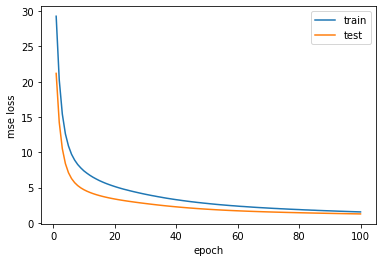

In [17]:
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.show()

Both training and test losses decrease in a standard way, given the plateau training for more than 100 epochs is unlikely to yield a much better model.

 ### Model Evaluation

With the model trained the first step for model evaluation is to get the predictions for the test set for the final model.

In [18]:
predictions = []
for i, (test_batch, label_batch) in enumerate(test_dataloader):
    count = 1 + i
    with torch.no_grad():
        prediction = MF_model(test_batch[:, 0].to(dev), test_batch[:, 1].to(dev))
        predictions.extend(list(prediction.cpu().numpy()))

For the metrics the MSE and the MAE will be used. The tdc module has a built in method for doing this so lets use that.

In [19]:
from tdc import Evaluator
mse_evaluator = Evaluator(name = 'MSE')
mae_evaluator = Evaluator(name = 'MAE')

mse_score = mse_evaluator(y_test, predictions)
mae_score = mae_evaluator(y_test, predictions)

print('MSE: ', mse_score)
print('MAE: ', mae_score)

MSE:  1.2677818285382438
MAE:  0.697870631545813


### Conclusion
The results look promising! However it is hard to evaluate them without a comparison. This same problem has been attempted by a fellow University of Sheffield student and their solution can be found [here](https://github.com/pykale/pykale/tree/main/examples/bindingdb_deepdta). Their method is called DeepDTA and uses convolutional nueral networks to represent the drugs and the targets before concatenating them to achieve the final prediction. While only the MSE is calculated for their model it still provides some comparison. A table comparing the results can be seen below.


| Model                | MSE  |
|----------------------|------|
| Matrix Factorisation | 1.27 |
| DeepDTA              | 0.74 |

While the model proposed here does not perform as well but it is still impressive given the relative simplicitiy of it. Therefore in an attempt to improve the model a new method is proposed to leverage the similarities between drugs and targets.

## Matrix Factorisation with Similarity Matrices
In matrix factorisation the prediction from the model is found via $A*B^T=Y$ where $Y$ is a matrix of predictions for the binding affinity. There are two additional conditions added by introducing similarity matrices:

$A*A^T=S_d$ (Drug similarity matrix)

$B*B^T=S_t$ (Target similarity matrix)


### Calculating Similarities
We'll start off by finding a method for obtaining the similarity between two drugs. There are a couple ways of doing this but for this project we'll use the dice similarity score. This is a multiple step process that involves the RDKit module. The first step is to convert the drug from a SMILE format into [rdkit.Chem.rdchem.Mol](https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Mol) object. From here this is then transformed into a morgan fingerprint which is used to find the dice similarity score. The following code block will demonstrate this for the first two unique drugs in the training set.

In [20]:
# load relevant RDKit modules
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

# Load in the first two unique drugs
unique_drugs = pd.unique(train['Drug'])

drug1 = unique_drugs[0]
drug2 = unique_drugs[1]

# Calculate the Mol object
mol1 = Chem.MolFromSmiles(drug1)
mol2 = Chem.MolFromSmiles(drug2)

# Now calculate the morgan fingerprint the Mol object
# the two corresponds to the radius of the morgan fingerprint, this is left as standard for this case
morg_fp1 = AllChem.GetMorganFingerprint(mol1, 2) 
morg_fp2 = AllChem.GetMorganFingerprint(mol2, 2)

# Caclulate and print the similarity score
drug_score = DataStructs.DiceSimilarity(morg_fp1, morg_fp2)
print('Dice Similarity Score: ', drug_score)

Dice Similarity Score:  0.5714285714285714


Now we have a method for calculating the similarity score between two drugs so this will be scaled up to calculate the similarity score between every unique drug in the training data set.

The next similarity matrix required is for the Targets. For this project the Target-Target similarity is calculated via the normalised smith-waterman score. This is done via the Bio module and in particular the Align package. This allows for easy sequence alignments. Again this will be tested on the first two unique targets in the training data set.

The equation below shows how the normalised Smith-Waterman score:
$$ \frac{score}{\sqrt{score1} \times \sqrt{score2}} $$
score is equal to the alignment score between the two targets and the score1 and score2 are the alignment scores between target1 and itself and target2 and itself.

In [21]:
from Bio import Align

# Load in the first two unique targets
unique_targets = pd.unique(train['Target'])

target1 = unique_targets[0]
target2 = unique_targets[1]

# Create a pairwise aligner object and verify it is Smith-Waterman
aligner = Align.PairwiseAligner()
aligner.mode = 'local'
#print('Algorithm is ', aligner.algorithm)

score = aligner.score(target1, target2)
score1 = aligner.score(target1, target1)
score2 = aligner.score(target2, target2)

norm_score = round((score / (np.sqrt(score1) * np.sqrt(score2))), 4)
print('Normalised Smith-Waterman score: ', norm_score)

Normalised Smith-Waterman score:  0.9942


Now we have a method for calculating the similarities between both drugs and targets.

### Calculating the Similarity Matrices
The code for calculating the full similarity matrices are below but due to the time taken to run they will be commented out and a link to download them will be provided. 

In [22]:
# drug_sim = np.zeros((len(unique_drugs), len(unique_drugs)))

# for i, drug1 in enumerate(tqdm(unique_drugs)):
#     mol1 = Chem.MolFromSmiles(drug1)
#     morg_fp1 = AllChem.GetMorganFingerprint(mol1, 2) 

#     for j, drug2 in enumerate(unique_drugs):
#         mol2 = Chem.MolFromSmiles(drug2)
#         morg_fp2 = AllChem.GetMorganFingerprint(mol2, 2)
        
#         drug_score = DataStructs.DiceSimilarity(morg_fp1, morg_fp2)
#         drug_sim[i][j] = round(drug_score, 4)
        
# np.savetxt('drug_sim.txt', drug_sim, delimiter=',')

In [23]:
# target_sim = np.zeros((len(unique_targets), len(unique_targets)))

# for i, target1 in enumerate(tqdm(unique_targets)):
#     score1 = aligner.score(target1, target1)
    
#     for j, target2 in enumerate(unique_targets):
#         score2 = aligner.score(target2, target2)
        
#         score = aligner.score(target1, target2)
        
#         norm_score = score / (np.sqrt(score1) * np.sqrt(score2))
#         target_sim[i][j] = round(norm_score, 4)
        
# np.savetxt('target_sim.txt', target_sim, delimiter=',')

In [24]:
# loading in previously calculated similarity matrices
drug_sim_np = np.loadtxt('SimilarityMatrices/drug_sim.txt', delimiter=',')
drug_sim = torch.from_numpy(drug_sim_np)

target_sim_np = np.loadtxt('SimilarityMatrices/target_sim.txt', delimiter=',')
target_sim = torch.from_numpy(target_sim_np)

With a similarity matrix for drugs and targets calculated can now begin creating the new model. 

### Creating the advanced model
The inspiration for this model is from a paper by Zheng et al and can be found [here](https://www.bic.kyoto-u.ac.jp/pathway/Files/kdd13.pdf). The initilisation of the class has a small addition where the model accepts the drug and target similarity matrices. 

The main changes to the class are to include the extra conditions:

$A*A^T=S_d$ (Drug similarity matrix)

$B*B^T=S_t$ (Target similarity matrix)




In [25]:
class MatrixFactorization(torch.nn.Module):

    def __init__(self, n_users, n_items, n_factors, drug_sim, target_sim):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.item_factors.weight)

        self.user_biases = torch.nn.Embedding(n_users, 1)
        self.item_biases = torch.nn.Embedding(n_items, 1)
        self.user_biases.weight.data.fill_(0.)
        self.item_biases.weight.data.fill_(0.)

        self.user_sim = drug_sim
        self.item_sim = target_sim

    def forward(self, user, item):
        AAT_list = [torch.dot(self.user_factors(user)[i, :], self.user_factors(user)[i, :]) for i in
                    range(self.user_factors(user).shape[0])]
        AAT = torch.tensor(AAT_list)

        Sd_partial = self.user_sim[user]
        Sd = Sd_partial[:, user]

        BBT_list = [torch.dot(self.item_factors(item)[i, :], self.item_factors(item)[i, :]) for i in
                    range(self.item_factors(item).shape[0])]
        BBT = torch.tensor(BBT_list)

        St_partial = self.user_sim[user]
        St = St_partial[:, user]

        pred = self.user_biases(user) + self.item_biases(item)
        pred += (self.user_factors(user) * self.item_factors(item)).sum(1, keepdim=True)

        drug_norm = 0.25 * torch.norm(Sd - AAT)
        target_norm = 0.25 * torch.norm(St - BBT)
        return pred.squeeze(), drug_norm, target_norm

In [26]:
n_factors = 20 # number of latent factors
num_epochs = 100

MFSM_model = MatrixFactorization(len(Drug_to_ID), len(Target_to_ID), n_factors, drug_sim, target_sim)

### Model Training

In [27]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
loss_func = torch.nn.MSELoss()

MFSM_model.to(dev)

train_losses = []
test_losses = []
for epoch in range(0, num_epochs):
    count = 0
    cum_loss = 0.
    for i, (train_batch, label_batch) in enumerate(train_dataloader):
        count = 1 + i
        # predict and calculate loss for item factor and bias
        optimizer = torch.optim.SGD([MFSM_model.user_biases.weight, MFSM_model.user_factors.weight, 
                                     MFSM_model.item_biases.weight, MFSM_model.item_factors.weight], lr=0.005,
                                    weight_decay=1e-5)
        prediction, drug_norm, target_norm = MFSM_model(train_batch[:, 0].to(dev), train_batch[:, 1].to(dev))
        loss = loss_func(prediction, label_batch.to(dev)).float() + drug_norm + target_norm
        loss_item = loss.item()
        cum_loss += loss_item

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
        optimizer.zero_grad()
        
    train_loss = cum_loss / count
    train_losses.append(train_loss)

    cum_loss = 0.
    count = 0
    for i, (test_batch, label_batch) in enumerate(test_dataloader):
        count = 1 + i
        with torch.no_grad():
            prediction, drug_norm, target_norm = MFSM_model(test_batch[:, 0].to(dev), test_batch[:, 1].to(dev))
            loss = loss_func(prediction, label_batch.to(dev))
            cum_loss += loss.item()

    test_loss = cum_loss / count
    test_losses.append(test_loss)
    if epoch % 5 == 0:
        print('epoch: ', epoch, ' avg training loss: ', train_loss, ' avg test loss: ', test_loss)

epoch:  0  avg training loss:  50.03054295949491  avg test loss:  33.06716309956142
epoch:  5  avg training loss:  43.10343099443166  avg test loss:  25.56904055731637
epoch:  10  avg training loss:  38.14817798884657  avg test loss:  20.28589532034738
epoch:  15  avg training loss:  34.5476729712351  avg test loss:  16.51148430960519
epoch:  20  avg training loss:  31.898263744346096  avg test loss:  13.776900686536516
epoch:  25  avg training loss:  29.917673638038966  avg test loss:  11.766262224742345
epoch:  30  avg training loss:  28.370293021623215  avg test loss:  10.265197927611215
epoch:  35  avg training loss:  27.19938923486432  avg test loss:  9.127170743261065
epoch:  40  avg training loss:  26.26554377017479  avg test loss:  8.25061935697283
epoch:  45  avg training loss:  25.483968652977737  avg test loss:  7.564916123662676
epoch:  50  avg training loss:  24.857048968385712  avg test loss:  7.0191827399390085
epoch:  55  avg training loss:  24.344712180232477  avg test

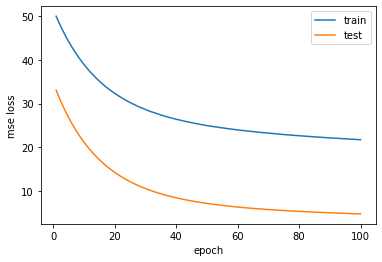

In [28]:
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_losses, label='train')
plt.plot(epochs, test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.show()

I'm not too sure why the training loss is so much higher than the test loss. A possible reason could be in the way they are calculated. The training loss is calculated while the model is still training whereas the test loss is calculated after the model has finished training on an epoch so will perform better.

### Model Evaluation

In [29]:
predictions = []
for i, (test_batch, label_batch) in enumerate(tqdm(test_dataloader)):
    count = 1 + i
    with torch.no_grad():
        prediction = MFSM_model(test_batch[:, 0].to(dev), test_batch[:, 1].to(dev))
        predictions.extend(list(prediction[0].cpu().numpy()))

100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:04<00:00, 32.60it/s]


In [30]:
mse_score = mse_evaluator(y_test, predictions)
mae_score = mae_evaluator(y_test, predictions)

print('MSE: ', mse_score)
print('MAE: ', mae_score)

MSE:  4.703316540461572
MAE:  1.3349805597398654


### Conclusion

That concludes the modelling part of this project. Unfortunately the advancement to the model did not improve the final result. The full table can be seen below with the results of both models from this notebook and the DeepDTA model mentioned previously. 

| Model                        | MSE  | MAE   |
|------------------------------|------|-------|
| Matrix Factorisation         | 1.99 | 0.70  |
| Matrix Factorisation with SM | 4.70 | 1.33  |
| DeepDTA                      | 0.74 | na    |

There are a couple improvements that could be tried to improve the final results. Firstly, while a cursory attempt at hyper parameter tuning was attempted this was far from exhaustive, therefore a more thorough attempt would be recommended. Parameters that could be tuned include batch size, number of factors, weight decay, and the weight of the similarity matrices. This would most likely provide a small increase in performance for both models.

For an improvement specific to the advanced model its recommended to add more similarity matrices for both drugs and targets. Currently only one is used for both however the paper that this model draws inspiration from uses multiple all with a weight that changes to ensure a higher quality similarity matrice has a greater importance.  

Thanks for reading through :) I'm welcome to any tips or suggestions as I'm just starting out with data science